# tf.data: Build TensorFlow input pipelines

The `tf.data` API enables you to build complex input pipelines from simple,
reusable pieces. For example, the pipeline for an image model might aggregate
data from files in a distributed file system, apply random perturbations to each
image, and merge randomly selected images into a batch for training. The
pipeline for a text model might involve extracting symbols from raw text data,
converting them to embedding identifiers with a lookup table, and batching
together sequences of different lengths. The `tf.data` API makes it possible to
handle large amounts of data, read from different data formats, and perform
complex transformations.

The `tf.data` API introduces a `tf.data.Dataset` abstraction that represents a
sequence of elements, in which each element consists of one or more components.
For example, in an image pipeline, an element might be a single training
example, with a pair of tensor components representing the image and its label.

There are two distinct ways to create a dataset:

*   A data **source** constructs a `Dataset` from data stored in memory or in
    one or more files.

*   A data **transformation** constructs a dataset from one or more
    `tf.data.Dataset` objects.


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## Basic mechanics

To create an input pipeline, you must start with a data *source*. For example,
to construct a `Dataset` from data in memory, you can use
`tf.data.Dataset.from_tensors()` or `tf.data.Dataset.from_tensor_slices()`.
Alternatively, if your input data is stored in a file in the recommended
TFRecord format, you can use `tf.data.TFRecordDataset()`.

Once you have a `Dataset` object, you can *transform* it into a new `Dataset` by
chaining method calls on the `tf.data.Dataset` object. For example, you can
apply per-element transformations such as `Dataset.map()`, and multi-element
transformations such as `Dataset.batch()`. See the documentation for
`tf.data.Dataset` for a complete list of transformations.

The `Dataset` object is a Python iterable. This makes it possible to consume its
elements using a for loop:

In [4]:
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [5]:
for elem in dataset:
    print(elem.numpy())

8
3
0
8
2
1


Or by explicitly creating a Python iterator using `iter` and consuming its
elements using `next`:

In [6]:
it = iter(dataset)

print(next(it).numpy())

8


Alternatively, dataset elements can be consumed using the `reduce`
transformation, which reduces all elements to produce a single result. The
following example illustrates how to use the `reduce` transformation to compute
the sum of a dataset of integers.

In [7]:
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


<!-- TODO(jsimsa): Talk about `tf.function` support. -->

<a id="dataset_structure"></a>
### Dataset structure

A dataset contains elements that each have the same (nested) structure and the
individual components of the structure can be of any type representable by
`tf.TypeSpec`, including `Tensor`, `SparseTensor`, `RaggedTensor`,
`TensorArray`, or `Dataset`.

The `Dataset.element_spec` property allows you to inspect the type of each
element component. The property returns a *nested structure* of `tf.TypeSpec`
objects, matching the structure of the element, which may be a single component,
a tuple of components, or a nested tuple of components. For example:

In [4]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))

dataset1.element_spec

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [9]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32))
)

dataset2.element_spec

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [10]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [11]:
# Dataset containing a sparse tensor.
dataset4 = tf.data.Dataset.from_tensors(tf.SparseTensor(indices=[[0, 0], [1, 2]], values=[1, 2], dense_shape=[3, 4]))

dataset4.element_spec

SparseTensorSpec(TensorShape([3, 4]), tf.int32)

In [12]:
# Use value_type to see the type of value represented by the element spec
dataset4.element_spec.value_type

tensorflow.python.framework.sparse_tensor.SparseTensor

The `Dataset` transformations support datasets of any structure. When using the
`Dataset.map()`, and `Dataset.filter()` transformations,
which apply a function to each element, the element structure determines the
arguments of the function:

In [13]:
dataset1 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval=1, maxval=10, dtype=tf.int32))

dataset1

<TensorSliceDataset shapes: (10,), types: tf.int32>

In [14]:
for z in dataset1:
    print(z.numpy())

[1 4 7 1 8 1 2 2 3 6]
[1 5 3 2 8 8 1 2 3 7]
[5 7 1 9 4 2 2 2 5 2]
[2 2 3 5 6 7 1 9 2 9]


In [15]:
dataset2 = tf.data.Dataset.from_tensor_slices(
   (tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval=100, dtype=tf.int32)))

dataset2

<TensorSliceDataset shapes: ((), (100,)), types: (tf.float32, tf.int32)>

In [16]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))

dataset3

<ZipDataset shapes: ((10,), ((), (100,))), types: (tf.int32, (tf.float32, tf.int32))>

In [17]:
for a, (b,c) in dataset3:
    print('shapes: {a.shape}, {b.shape}, {c.shape}'.format(a=a, b=b, c=c))

shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)
shapes: (10,), (), (100,)


## Reading input data


### Consuming NumPy arrays

See [Loading NumPy arrays](../tutorials/load_data/numpy.ipynb) for more examples.

If all of your input data fits in memory, the simplest way to create a `Dataset`
from them is to convert them to `tf.Tensor` objects and use
`Dataset.from_tensor_slices()`.

In [18]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [19]:
images, labels = train
images = images/255

dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset

<TensorSliceDataset shapes: ((28, 28), ()), types: (tf.float64, tf.uint8)>

Note: The above code snippet will embed the `features` and `labels` arrays
in your TensorFlow graph as `tf.constant()` operations. This works well for a
small dataset, but wastes memory---because the contents of the array will be
copied multiple times---and can run into the 2GB limit for the `tf.GraphDef`
protocol buffer.

### Consuming Python generators

Another common data source that can easily be ingested as a `tf.data.Dataset` is the python generator.

Caution: While this is a convienient approach it has limited portability and scalibility. It must run in the same python process that created the generator, and is still subject to the Python [GIL](https://en.wikipedia.org/wiki/Global_interpreter_lock).

In [20]:
def count(stop):
    i = 0
    while i<stop:
        yield i
        i += 1

In [21]:
for n in count(5):
    print(n)

0
1
2
3
4


The `Dataset.from_generator` constructor converts the python generator to a fully functional `tf.data.Dataset`.

The constructor takes a callable as input, not an iterator. This allows it to restart the generator when it reaches the end. It takes an optional `args` argument, which is passed as the callable's arguments.

The `output_types` argument is required because `tf.data` builds a `tf.Graph` internally, and graph edges require a `tf.dtype`.

In [22]:
ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [23]:
for count_batch in ds_counter.repeat().batch(10).take(10):
    print(count_batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]
[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24  0  1  2  3  4]
[ 5  6  7  8  9 10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]


The `output_shapes` argument is not *required* but is highly recomended as many tensorflow operations do not support tensors with unknown rank. If the length of a particular axis is unknown or variable, set it as `None` in the `output_shapes`.

It's also important to note that the `output_shapes` and `output_types` follow the same nesting rules as other dataset methods.

Here is an example generator that demonstrates both aspects, it returns tuples of arrays, where the second array is a vector with unknown length.

In [24]:
def gen_series():
    i = 0
    while True:
        size = np.random.randint(0, 10)
        yield i, np.random.normal(size=(size,))
        i += 1

In [25]:
for i, series in gen_series():
    print(i, ":", str(series))
    if i > 5:
        break

0 : [-0.8371 -0.1839]
1 : [ 0.2395 -0.098   2.3523 -0.2753  0.8974]
2 : [ 0.0517  1.1118 -0.3403  0.5114 -1.4794 -1.322   0.9967]
3 : [0.519  0.7133]
4 : [-0.0495  0.4219 -0.4239 -1.5561  1.268  -0.0122  0.1343]
5 : [-0.0347  0.1583]
6 : [-0.2157  1.8255 -0.354  -0.2228  0.159   0.8378 -1.7499 -1.482 ]


The first output is an `int32` the second is a `float32`.

The first item is a scalar, shape `()`, and the second is a vector of unknown length, shape `(None,)` 

In [26]:
ds_series = tf.data.Dataset.from_generator(
    gen_series, 
    output_types=(tf.int32, tf.float32), 
    output_shapes=((), (None,)))

ds_series

<DatasetV1Adapter shapes: ((), (None,)), types: (tf.int32, tf.float32)>

Now it can be used like a regular `tf.data.Dataset`. Note that when batching a dataset with a variable shape, you need to use `Dataset.padded_batch`.

In [33]:
ds_series_batch = ds_series.shuffle(20).padded_batch(10, padded_shapes=([],[None]))

ids, sequence_batch = next(iter(ds_series_batch))
print(ids.numpy())
print()
print(sequence_batch.numpy())

[18  4  2 12 19  6 20 22 11 10]

[[-0.8331 -1.4527 -0.7898  0.0466  2.3274 -0.922  -0.4158  0.2566  0.0338]
 [ 1.0818  0.0281  0.2566  0.5579  0.5964 -1.4614  3.0373  1.5211 -0.3293]
 [-0.2071  0.3876  0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.8481 -2.4253  0.5349 -1.2858 -0.2966  1.058   0.9183  0.      0.    ]
 [ 1.1482  1.0337  0.5598  0.0662 -0.5279  0.3964  0.      0.      0.    ]
 [-0.4267 -0.6065  0.8907 -0.1351 -0.1904  0.3835 -0.6779  0.      0.    ]
 [-0.0532 -1.4277  0.8397 -1.2536  0.5939 -1.7617 -0.4683  0.6496  3.1312]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-0.4343  1.3823 -0.8446  1.1978  0.5975  0.      0.      0.      0.    ]]


For a more realistic example, try wrapping `preprocessing.image.ImageDataGenerator` as a `tf.data.Dataset`.

First download the data:

In [28]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 156s 1us/step


Create the `image.ImageDataGenerator`

In [34]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, rotation_range=20)

In [35]:
images, labels = next(img_gen.flow_from_directory(flowers))

Found 3670 images belonging to 5 classes.


In [36]:
print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

float32 (32, 256, 256, 3)
float32 (32, 5)


In [37]:
ds = tf.data.Dataset.from_generator(
    img_gen.flow_from_directory, args=[flowers], 
    output_types=(tf.float32, tf.float32), 
    output_shapes=([32,256,256,3], [32,5])
)

ds

<DatasetV1Adapter shapes: ((32, 256, 256, 3), (32, 5)), types: (tf.float32, tf.float32)>

### Consuming TFRecord data

See [Loading TFRecords](../tutorials/load_data/tf_records.ipynb) for an end-to-end example.

The `tf.data` API supports a variety of file formats so that you can process
large datasets that do not fit in memory. For example, the TFRecord file format
is a simple record-oriented binary format that many TensorFlow applications use
for training data. The `tf.data.TFRecordDataset` class enables you to
stream over the contents of one or more TFRecord files as part of an input
pipeline.

Here is an example using the test file from the French Street Name Signs (FSNS).

In [38]:
# Creates a dataset that reads all of the examples from two files.
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")

7905280/7904079 [==============================] - 11s 1us/step


The `filenames` argument to the `TFRecordDataset` initializer can either be a
string, a list of strings, or a `tf.Tensor` of strings. Therefore if you have
two sets of files for training and validation purposes, you can create a factory
method that produces the dataset, taking filenames as an input argument:


In [39]:
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

Many TensorFlow projects use serialized `tf.train.Example` records in their TFRecord files. These need to be decoded before they can be inspected:

In [40]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

parsed.features.feature['image/text']

bytes_list {
  value: "Rue Perreyon"
}

### Consuming text data

See [Loading Text](../tutorials/load_data/text.ipynb) for an end to end example.

Many datasets are distributed as one or more text files. The
`tf.data.TextLineDataset` provides an easy way to extract lines from one or more
text files. Given one or more filenames, a `TextLineDataset` will produce one
string-valued element per line of those files.

In [41]:
directory_url = 'https://storage.googleapis.com/download.tensorflow.org/data/illiad/'
file_names = ['cowper.txt', 'derby.txt', 'butler.txt']

file_paths = [
    tf.keras.utils.get_file(file_name, directory_url + file_name)
    for file_name in file_names
]

811008/807992 [==============================] - 3s 4us/step


In [42]:
dataset = tf.data.TextLineDataset(file_paths)

Here are the first few lines of the first file:

In [43]:
for line in dataset.take(5):
    print(line.numpy())

b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b'His wrath pernicious, who ten thousand woes'
b"Caused to Achaia's host, sent many a soul"
b'Illustrious into Ades premature,'
b'And Heroes gave (so stood the will of Jove)'


To alternate lines between files use `Dataset.interleave`. This makes it easier to shuffle files together. Here are the first, second and third lines from each translation:

In [44]:
files_ds = tf.data.Dataset.from_tensor_slices(file_paths)
lines_ds = files_ds.interleave(tf.data.TextLineDataset, cycle_length=3)

for i, line in enumerate(lines_ds.take(9)):
    if i % 3 == 0:
        print()
    print(line.numpy())


b"\xef\xbb\xbfAchilles sing, O Goddess! Peleus' son;"
b"\xef\xbb\xbfOf Peleus' son, Achilles, sing, O Muse,"
b'\xef\xbb\xbfSing, O goddess, the anger of Achilles son of Peleus, that brought'

b'His wrath pernicious, who ten thousand woes'
b'The vengeance, deep and deadly; whence to Greece'
b'countless ills upon the Achaeans. Many a brave soul did it send'

b"Caused to Achaia's host, sent many a soul"
b'Unnumbered ills arose; which many a soul'
b'hurrying down to Hades, and many a hero did it yield a prey to dogs and'


By default, a `TextLineDataset` yields *every* line of each file, which may
not be desirable, for example, if the file starts with a header line, or contains comments. These lines can be removed using the `Dataset.skip()` or
`Dataset.filter()` transformations. Here, you skip the first line, then filter to
find only survivors.

In [45]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

32768/30874 [===============================] - 1s 21us/step


In [46]:
for line in titanic_lines.take(10):
    print(line.numpy())

b'survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone'
b'0,male,22.0,1,0,7.25,Third,unknown,Southampton,n'
b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y'
b'0,male,2.0,3,1,21.075,Third,unknown,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'


In [47]:
def survived(line):
    return tf.not_equal(tf.strings.substr(line, 0, 1), "0")

survivors = titanic_lines.skip(1).filter(survived)

In [48]:
for line in survivors.take(10):
    print(line.numpy())

b'1,female,38.0,1,0,71.2833,First,C,Cherbourg,n'
b'1,female,26.0,0,0,7.925,Third,unknown,Southampton,y'
b'1,female,35.0,1,0,53.1,First,C,Southampton,n'
b'1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n'
b'1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n'
b'1,female,4.0,1,1,16.7,Third,G,Southampton,n'
b'1,male,28.0,0,0,13.0,Second,unknown,Southampton,y'
b'1,female,28.0,0,0,7.225,Third,unknown,Cherbourg,y'
b'1,male,28.0,0,0,35.5,First,A,Southampton,y'
b'1,female,38.0,1,5,31.3875,Third,unknown,Southampton,n'


### Consuming CSV data

See [Loading CSV Files](../tutorials/load_data/csv.ipynb), and [Loading Pandas DataFrames](../tutorials/load_data/pandas.ipynb) for more examples. 

The CSV file format is a popular format for storing tabular data in plain text.

For example:

In [49]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [50]:
df = pd.read_csv(titanic_file, index_col=None)
df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


If your data fits in memory the same `Dataset.from_tensor_slices` method works on dictionaries, allowing this data to be easily imported:

In [51]:
titanic_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in titanic_slices.take(1):
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

  'survived'          : 0
  'sex'               : b'male'
  'age'               : 22.0
  'n_siblings_spouses': 1
  'parch'             : 0
  'fare'              : 7.25
  'class'             : b'Third'
  'deck'              : b'unknown'
  'embark_town'       : b'Southampton'
  'alone'             : b'n'


A more scalable approach is to load from disk as necessary. 

The `tf.data` module provides methods to extract records from one or more CSV files that comply with [RFC 4180](https://tools.ietf.org/html/rfc4180).

The `experimental.make_csv_dataset` function is the high level interface for reading sets of csv files. It supports column type inference and many other features, like batching and shuffling, to make usage simple.

In [52]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived")

Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.


In [53]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 1 1]
features:
  'sex'               : [b'male' b'male' b'female' b'female']
  'age'               : [25. 37. 51. 28.]
  'n_siblings_spouses': [1 2 1 1]
  'parch'             : [0 0 0 0]
  'fare'              : [17.8     7.925  77.9583 15.5   ]
  'class'             : [b'Third' b'Third' b'First' b'Third']
  'deck'              : [b'unknown' b'unknown' b'D' b'unknown']
  'embark_town'       : [b'Southampton' b'Southampton' b'Southampton' b'Queenstown']
  'alone'             : [b'n' b'n' b'n' b'n']


You can use the `select_columns` argument if you only need a subset of columns.

In [54]:
titanic_batches = tf.data.experimental.make_csv_dataset(
    titanic_file, batch_size=4,
    label_name="survived", select_columns=['class', 'fare', 'survived'])

In [55]:
for feature_batch, label_batch in titanic_batches.take(1):
    print("'survived': {}".format(label_batch))
    for key, value in feature_batch.items():
        print("  {!r:20s}: {}".format(key, value))

'survived': [0 0 0 0]
  'fare'              : [15.5    31.275   7.8958  7.7333]
  'class'             : [b'Third' b'Third' b'Third' b'Third']


There is also a lower-level `experimental.CsvDataset` class which provides finer grained control. It does not support column type inference. Instead you must specify the type of each column. 

In [56]:
titanic_types  = [tf.int32, tf.string, tf.float32, tf.int32, tf.int32, tf.float32, tf.string, tf.string, tf.string, tf.string] 
dataset = tf.data.experimental.CsvDataset(titanic_file, titanic_types , header=True)

for line in dataset.take(10):
    print([item.numpy() for item in line])

[0, b'male', 22.0, 1, 0, 7.25, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 38.0, 1, 0, 71.2833, b'First', b'C', b'Cherbourg', b'n']
[1, b'female', 26.0, 0, 0, 7.925, b'Third', b'unknown', b'Southampton', b'y']
[1, b'female', 35.0, 1, 0, 53.1, b'First', b'C', b'Southampton', b'n']
[0, b'male', 28.0, 0, 0, 8.4583, b'Third', b'unknown', b'Queenstown', b'y']
[0, b'male', 2.0, 3, 1, 21.075, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 27.0, 0, 2, 11.1333, b'Third', b'unknown', b'Southampton', b'n']
[1, b'female', 14.0, 1, 0, 30.0708, b'Second', b'unknown', b'Cherbourg', b'n']
[1, b'female', 4.0, 1, 1, 16.7, b'Third', b'G', b'Southampton', b'n']
[0, b'male', 20.0, 0, 0, 8.05, b'Third', b'unknown', b'Southampton', b'y']


If some columns are empty, this low-level interface allows you to provide default values instead of column types.

In [57]:
%%writefile missing.csv
1,2,3,4
,2,3,4
1,,3,4
1,2,,4
1,2,3,
,,,

Writing missing.csv


In [58]:
# Creates a dataset that reads all of the records from two CSV files, each with
# four float columns which may have missing values.

record_defaults = [999,999,999,999]
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults)
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (4,), types: tf.int32>

In [59]:
for line in dataset:
    print(line.numpy())

[1 2 3 4]
[999   2   3   4]
[  1 999   3   4]
[  1   2 999   4]
[  1   2   3 999]
[999 999 999 999]


By default, a `CsvDataset` yields *every* column of *every* line of the file,
which may not be desirable, for example if the file starts with a header line
that should be ignored, or if some columns are not required in the input.
These lines and fields can be removed with the `header` and `select_cols`
arguments respectively.

In [60]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("missing.csv", record_defaults, select_cols=[1, 3])
dataset = dataset.map(lambda *items: tf.stack(items))
dataset

<MapDataset shapes: (2,), types: tf.int32>

In [61]:
for line in dataset:
    print(line.numpy())

[2 4]
[2 4]
[999   4]
[2 4]
[  2 999]
[999 999]


### Consuming sets of files

There are many datasets distributed as a set of files, where each file is an example.

In [62]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

Note: these images are licensed CC-BY, see LICENSE.txt for details.

The root directory contains a directory for each class:

In [63]:
for item in flowers_root.glob("*"):
    print(item.name)

sunflowers
tulips
daisy
dandelion
roses
LICENSE.txt


The files in each class directory are examples:

In [64]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'/home/pedro/.keras/datasets/flower_photos/daisy/5434913005_409c1e8b56_n.jpg'
b'/home/pedro/.keras/datasets/flower_photos/sunflowers/265450085_6e9f276e2e.jpg'
b'/home/pedro/.keras/datasets/flower_photos/dandelion/10778387133_9141024b10.jpg'
b'/home/pedro/.keras/datasets/flower_photos/roses/15333843782_060cef3030.jpg'
b'/home/pedro/.keras/datasets/flower_photos/dandelion/5745882709_fb6fc8f02a_n.jpg'


Read the data using the `tf.io.read_file` function and extract the label from the path, returning `(image, label)` pairs:

In [65]:
def process_path(file_path):
    label = tf.strings.split(file_path, '/')[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [66]:
for image_raw, label_text in labeled_ds.take(1):
    print(repr(image_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'

b'sunflowers'


<!--
TODO(mrry): Add this section.

### Handling text data with unusual sizes
-->

## Batching dataset elements


### Simple batching

The simplest form of batching stacks `n` consecutive elements of a dataset into
a single element. The `Dataset.batch()` transformation does exactly this, with
the same constraints as the `tf.stack()` operator, applied to each component
of the elements: i.e. for each component *i*, all elements must have a tensor
of the exact same shape.

In [67]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

for batch in batched_dataset.take(4):
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3]), array([ 0, -1, -2, -3])]
[array([4, 5, 6, 7]), array([-4, -5, -6, -7])]
[array([ 8,  9, 10, 11]), array([ -8,  -9, -10, -11])]
[array([12, 13, 14, 15]), array([-12, -13, -14, -15])]


While `tf.data` tries to propagate shape information, the default settings of `Dataset.batch` result in an unknown batch size because the last batch may not be full. Note the `None`s in the shape:

In [68]:
batched_dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.int64)>

Use the `drop_remainder` argument to ignore that last batch, and get full shape propagation:

In [69]:
batched_dataset = dataset.batch(7, drop_remainder=True)
batched_dataset

<BatchDataset shapes: ((7,), (7,)), types: (tf.int64, tf.int64)>

### Batching tensors with padding

The above recipe works for tensors that all have the same size. However, many
models (e.g. sequence models) work with input data that can have varying size
(e.g. sequences of different lengths). To handle this case, the
`Dataset.padded_batch` transformation enables you to batch tensors of
different shape by specifying one or more dimensions in which they may be
padded.

In [70]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes=(None,))

for batch in dataset.take(2):
    print(batch.numpy())
    print()


[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



The `Dataset.padded_batch` transformation allows you to set different padding
for each dimension of each component, and it may be variable-length (signified
by `None` in the example above) or constant-length. It is also possible to
override the padding value, which defaults to 0.

<!--
TODO(mrry): Add this section.

### Dense ragged -> tf.SparseTensor
-->


## Training workflows


### Processing multiple epochs

The `tf.data` API offers two main ways to process multiple epochs of the same
data.

The simplest way to iterate over a dataset in multiple epochs is to use the
`Dataset.repeat()` transformation. First, create a dataset of titanic data:

In [71]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [72]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

Applying the `Dataset.repeat()` transformation with no arguments will repeat
the input indefinitely.

The `Dataset.repeat` transformation concatenates its
arguments without signaling the end of one epoch and the beginning of the next
epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batches that straddle epoch boundaries:

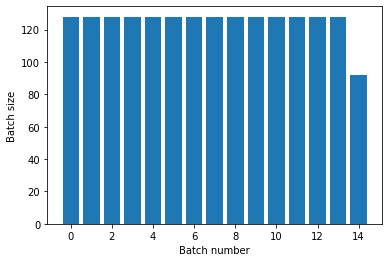

In [73]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

If you need clear epoch separation, put `Dataset.batch` before the repeat:

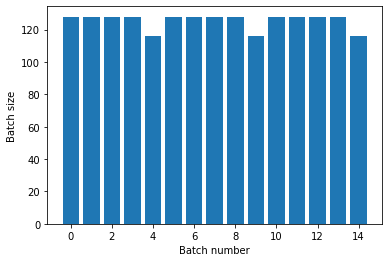

In [74]:
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [76]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


### Randomly shuffling input data

The `Dataset.shuffle()` transformation maintains a fixed-size
buffer and chooses the next element uniformly at random from that buffer.

Note: While large buffer_sizes shuffle more thoroughly, they can take a lot of memory, and significant time to fill. Consider using `Dataset.interleave` across files if this becomes a problem.

Add an index to the dataset so you can see the effect:

In [77]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset shapes: ((None,), (None,)), types: (tf.int64, tf.string)>

Since the `buffer_size` is 100, and the batch size is 20, the first batch contains no elements with an index over 120.

In [78]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 81   2 101  16  96  24  33  23  29  58  41  83  54  78  99  30 102 114
  31  71]


As with `Dataset.batch` the order relative to `Dataset.repeat` matters.

`Dataset.shuffle` doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next: 

In [79]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[ 65 598 393 174 503 537 504 575 576 592]
[624 468 412 627 603 615 531 612 389 441]
[494 546 429 586 448 620 604 596]
[23 11 15 41 27 17 75 29 35 67]
[ 58 109   4 112  32  79  69  77  18  16]


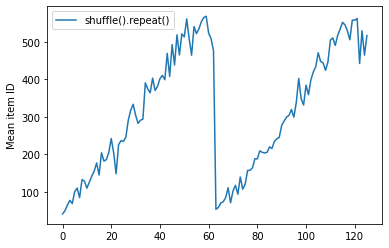

In [80]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

But a repeat before a shuffle mixes the epoch boundaries together:

In [81]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[624  18 375   6 557 494  11  22 582 542]
[618  28 499 550 128 619 583  33  34 540]
[466 371 502 596  40  15  42 586 611 498]
[ 23 587 576  37 504 529  30   8  43 626]
[ 59  12  24  35 517 588 578  46 509  39]
[456  50 603 434  32  17 525 625 575  68]
[623  72 531   4  55  60  57 520  70 552]
[ 82  64 606 476  85   9 549 592  14  98]
[ 67  99 608 493  25  88 105  49  84 422]
[ 73  93  63  54  58 591  80 598 532 101]
[ 44 556 551   2  61 610 604 106  56 103]
[ 21  96 102 416 130  31  79  47 597 131]
[ 97 569  81 133 109 104 145 414 126 559]
[ 48  65 118  71 314 512 113  66  36  52]
[138   5  86 473 117  95 620 129 108 155]


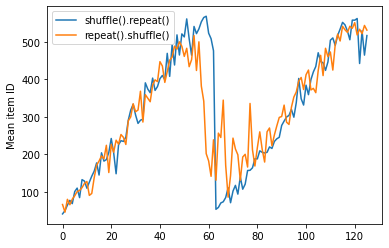

In [82]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

## Preprocessing data

The `Dataset.map(f)` transformation produces a new dataset by applying a given
function `f` to each element of the input dataset. It is based on the
[`map()`](https://en.wikipedia.org/wiki/Map_\(higher-order_function\)) function
that is commonly applied to lists (and other structures) in functional
programming languages. The function `f` takes the `tf.Tensor` objects that
represent a single element in the input, and returns the `tf.Tensor` objects
that will represent a single element in the new dataset. Its implementation uses
standard TensorFlow operations to transform one element into another.

This section covers common examples of how to use `Dataset.map()`.


### Decoding image data and resizing it

<!-- TODO(markdaoust): link to image augmentation when it exists -->
When training a neural network on real-world image data, it is often necessary
to convert images of different sizes to a common size, so that they may be
batched into a fixed size.

Rebuild the flower filenames dataset:

In [83]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

Write a function that manipulates the dataset elements.

In [84]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, '/')
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

Test that it works.

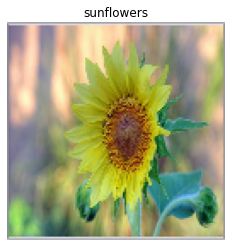

In [85]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

Map it over the dataset.

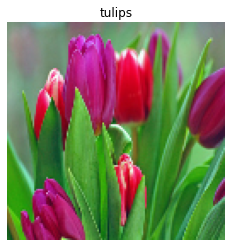

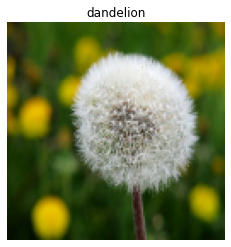

In [86]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
    show(image, label)

### Applying arbitrary Python logic

For performance reasons, use TensorFlow operations for
preprocessing your data whenever possible. However, it is sometimes useful to
call external Python libraries when parsing your input data. You can use the `tf.py_function()` operation in a `Dataset.map()` transformation.

For example, if you want to apply a random rotation, the `tf.image` module only has `tf.image.rot90`, which is not very useful for image augmentation. 

Note: `tensorflow_addons` has a TensorFlow compatible `rotate` in `tensorflow_addons.image.rotate`.

To demonstrate `tf.py_function`, try using the `scipy.ndimage.rotate` function instead:

In [87]:
import scipy.ndimage as ndimage

def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


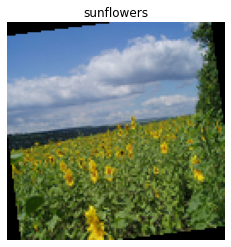

In [88]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

To use this function with `Dataset.map` the same caveats apply as with `Dataset.from_generator`, you need to describe the return shapes and types when you apply the function:

In [89]:
def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


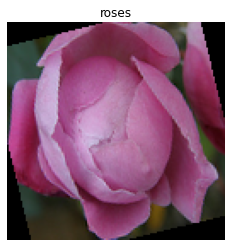

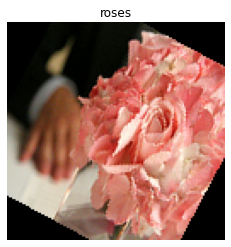

In [90]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
    show(image, label)

### Parsing `tf.Example` protocol buffer messages

Many input pipelines extract `tf.train.Example` protocol buffer messages from a
TFRecord format. Each `tf.train.Example` record contains one or more "features",
and the input pipeline typically converts these features into tensors.

In [91]:
fsns_test_file = tf.keras.utils.get_file("fsns.tfrec", "https://storage.googleapis.com/download.tensorflow.org/data/fsns-20160927/testdata/fsns-00000-of-00001")
dataset = tf.data.TFRecordDataset(filenames = [fsns_test_file])
dataset

<TFRecordDatasetV2 shapes: (), types: tf.string>

You can work with `tf.train.Example` protos outside of a `tf.data.Dataset` to understand the data:

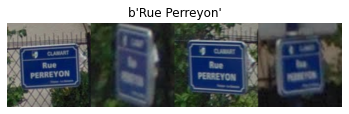

In [92]:
raw_example = next(iter(dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]
img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/text"].bytes_list.value[0])

In [93]:
raw_example = next(iter(dataset))

In [94]:
def tf_parse(eg):
    example = tf.io.parse_example(
        eg[tf.newaxis], {
            'image/encoded': tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            'image/text': tf.io.FixedLenFeature(shape=(), dtype=tf.string)
        })
    return example['image/encoded'][0], example['image/text'][0]

In [95]:
img, txt = tf_parse(raw_example)
print(txt.numpy())
print(repr(img.numpy()[:20]), "...")

b'Rue Perreyon'
b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X' ...


In [96]:
decoded = dataset.map(tf_parse)
decoded

<MapDataset shapes: ((), ()), types: (tf.string, tf.string)>

In [97]:
image_batch, text_batch = next(iter(decoded.batch(10)))
image_batch.shape

TensorShape([10])

<a id="time_series_windowing"></a>

### Time series windowing

For an end to end time series example see: [Time series forecasting](../../tutorials/text/time_series.ipynb).

Time series data is often organized with the time axis intact.

Use a simple `Dataset.range` to demonstrate:

In [98]:
range_ds = tf.data.Dataset.range(100000)

Typically, models based on this sort of data will want a contiguous time slice. 

The simplest approach would be to batch the data:

#### Using `batch`

In [99]:
batches = range_ds.batch(10, drop_remainder=True)

for batch in batches.take(5):
    print(batch.numpy())

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]
[40 41 42 43 44 45 46 47 48 49]


Or to make dense predictions one step into the future, you might shift the features and labels by one step relative to each other:

In [100]:
def dense_1_step(batch):
  # Shift features and labels one step relative to each other.
  return batch[:-1], batch[1:]

predict_dense_1_step = batches.map(dense_1_step)

for features, label in predict_dense_1_step.take(3):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8]  =>  [1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18]  =>  [11 12 13 14 15 16 17 18 19]
[20 21 22 23 24 25 26 27 28]  =>  [21 22 23 24 25 26 27 28 29]


To predict a whole window instead of a fixed offset you can split the batches into two parts:

In [101]:
batches = range_ds.batch(15, drop_remainder=True)

def label_next_5_steps(batch):
    return (batch[:-5],   # Take the first 5 steps
            batch[-5:])   # take the remainder

predict_5_steps = batches.map(label_next_5_steps)

for features, label in predict_5_steps.take(3):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[15 16 17 18 19 20 21 22 23 24]  =>  [25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39]  =>  [40 41 42 43 44]


To allow some overlap between the features of one batch and the labels of another, use `Dataset.zip`:

In [102]:
feature_length = 10
label_length = 5

features = range_ds.batch(feature_length, drop_remainder=True)
labels = range_ds.batch(feature_length).skip(1).map(lambda labels: labels[:-5])

predict_5_steps = tf.data.Dataset.zip((features, labels))

for features, label in predict_5_steps.take(3):
    print(features.numpy(), " => ", label.numpy())

[0 1 2 3 4 5 6 7 8 9]  =>  [10 11 12 13 14]
[10 11 12 13 14 15 16 17 18 19]  =>  [20 21 22 23 24]
[20 21 22 23 24 25 26 27 28 29]  =>  [30 31 32 33 34]


#### Using `window`

While using `Dataset.batch` works, there are situations where you may need finer control. The `Dataset.window` method gives you complete control, but requires some care: it returns a `Dataset` of `Datasets`. See [Dataset structure](#dataset_structure) for details.

In [103]:
window_size = 5

windows = range_ds.window(window_size, shift=1)
for sub_ds in windows.take(5):
    print(sub_ds)

<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>
<_VariantDataset shapes: (), types: tf.int64>


The `Dataset.flat_map` method can take a dataset of datasets and flatten it into a single dataset:

In [104]:
 for x in windows.flat_map(lambda x: x).take(30):
     print(x.numpy(), end=' ')

for x in windows.flat_map(lambda x: x).take(30):

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
for x in windows.flat_map(lambda x: x).take(30):

If this is a lambda function, the error may be avoided by creating the lambda in a standalone statement.
0 1 2 3 4 1 2 3 4 5 2 3 4 5 6 3 4 5 6 7 4 5 6 7 8 5 6 7 8 9 

In nearly all cases, you will want to `.batch` the dataset first:

In [105]:
def sub_to_batch(sub):
    return sub.batch(window_size, drop_remainder=True)

for example in windows.flat_map(sub_to_batch).take(5):
    print(example.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]


Now, you can see that the `shift` argument controls how much each window moves over.

Putting this together you might write this function:

In [107]:
def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    windows = ds.window(window_size, shift=shift, stride=stride)

    def sub_to_batch(sub):
        return sub.batch(window_size, drop_remainder=True)

    windows = windows.flat_map(sub_to_batch)
    return windows

In [108]:
ds = make_window_dataset(range_ds, window_size=10, shift = 5, stride=3)

for example in ds.take(10):
    print(example.numpy())

[ 0  3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34 37]
[15 18 21 24 27 30 33 36 39 42]
[20 23 26 29 32 35 38 41 44 47]
[25 28 31 34 37 40 43 46 49 52]
[30 33 36 39 42 45 48 51 54 57]
[35 38 41 44 47 50 53 56 59 62]
[40 43 46 49 52 55 58 61 64 67]
[45 48 51 54 57 60 63 66 69 72]


Then it's easy to extract labels, as before:

In [109]:
dense_labels_ds = ds.map(dense_1_step)

for inputs,labels in dense_labels_ds.take(3):
    print(inputs.numpy(), "=>", labels.numpy())

[ 0  3  6  9 12 15 18 21 24] => [ 3  6  9 12 15 18 21 24 27]
[ 5  8 11 14 17 20 23 26 29] => [ 8 11 14 17 20 23 26 29 32]
[10 13 16 19 22 25 28 31 34] => [13 16 19 22 25 28 31 34 37]


### Resampling

When working with a dataset that is very class-imbalanced, you may want to resample the dataset. `tf.data` provides two methods to do this. The credit card fraud dataset is a good example of this sort of problem.

Note: See [Imbalanced Data](../tutorials/keras/imbalanced_data.ipynb) for a full tutorial.


In [110]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/download.tensorflow.org/data/creditcard.zip',
    fname='creditcard.zip',
    extract=True)

csv_path = zip_path.replace('.zip', '.csv')

69156864/69155632 [==============================] - 43s 1us/step


In [111]:
creditcard_ds = tf.data.experimental.make_csv_dataset(
    csv_path, batch_size=1024, label_name="Class",
    # Shuffled datasets don't work with rejection resample in TF2.1
    shuffle = False, 
    # Set the column types: 30 floats and an int.
    column_defaults=[float()]*30+[int()])

Now, check the distribution of classes, it is highly skewed:

In [112]:
def count(counts, batch):
    features, labels = batch
    class_1 = labels == 1
    class_1 = tf.cast(class_1, tf.int32)

    class_0 = labels == 0
    class_0 = tf.cast(class_0, tf.int32)

    counts['class_0'] += tf.reduce_sum(class_0)
    counts['class_1'] += tf.reduce_sum(class_1)

    return counts

In [113]:
counts = creditcard_ds.take(10).reduce(
    initial_state={'class_0': 0, 'class_1': 0},
    reduce_func = count)

counts = np.array([counts['class_0'].numpy(),
                   counts['class_1'].numpy()]).astype(np.float32)

fractions = counts/counts.sum()
print(fractions)

[0.9962 0.0038]


A common approach to training with an imbalanced dataset is to balance it. `tf.data` includes a few methods which enable this workflow:

#### Datasets sampling

One approach to resampling a dataset is to use `sample_from_datasets`. This is more applicable when you have a separate `data.Dataset` for each class.

Here, just use filter to generate them from the credit card fraud data:

In [114]:
negative_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==0)
    .repeat())
positive_ds = (
  creditcard_ds
    .unbatch()
    .filter(lambda features, label: label==1)
    .repeat())

In [115]:
for features, label in positive_ds.batch(10).take(1):
    print(label.numpy())

[1 1 1 1 1 1 1 1 1 1]


To use `tf.data.experimental.sample_from_datasets` pass the datasets, and the weight for each:

In [116]:
balanced_ds = tf.data.experimental.sample_from_datasets(
    [negative_ds, positive_ds], [0.5, 0.5]).shuffle(100).batch(10)

Now the dataset produces examples of each class with 50/50 probability:

In [117]:
for features, labels in balanced_ds.take(10):
    print(labels.numpy())

[1 0 0 0 1 1 0 0 1 1]
[0 0 0 1 0 0 1 1 0 1]
[1 0 1 1 1 0 0 1 0 0]
[1 0 1 0 1 0 1 0 1 0]
[1 1 0 0 1 1 0 1 0 1]
[1 0 0 0 0 1 0 1 0 1]
[1 1 0 1 1 0 1 1 1 0]
[0 1 1 1 0 1 1 0 0 0]
[0 1 1 0 0 1 0 1 1 0]
[0 1 1 0 0 1 0 1 0 0]


#### Rejection resampling

One problem with the above `experimental.sample_from_datasets` approach is that
it needs a separate `tf.data.Dataset` per class. Using `Dataset.filter`
works, but results in all the data being loaded twice.

The `data.experimental.rejection_resample` function can be applied to a dataset to rebalance it, while only loading it once. Elements will be dropped from the dataset to achieve balance.

`data.experimental.rejection_resample` takes a `class_func` argument. This `class_func` is applied to each dataset element, and is used to determine which class an example belongs to for the purposes of balancing.

Caution: This function only works correctly of the dataset returns the same sequence of elements on each run. Don't pass a shuffled dataset to  `rejection_resample`.

The elements of `creditcard_ds` are already `(features, label)` pairs. So the `class_func` just needs to return those labels:

In [118]:
def class_func(features, label):
    return label

The resampler also needs a target distribution, and optionally an initial distribution estimate:

In [119]:
resampler = tf.data.experimental.rejection_resample(
    class_func, target_dist=[0.5, 0.5], initial_dist=fractions)

The resampler deals with individual examples, so you must `unbatch` the dataset before applying the resampler:

In [120]:
resample_ds = creditcard_ds.unbatch().apply(resampler).shuffle(100).batch(10)

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:



The resampler returns creates `(class, example)` pairs from the output of the `class_func`. In this case, the `example` was already a `(feature, label)` pair, so use `map` to drop the extra copy of the labels:

In [121]:
balanced_ds = resample_ds.map(lambda extra_label, features_and_label: features_and_label)

Now the dataset produces examples of each class with 50/50 probability:

In [122]:
for features, labels in balanced_ds.take(10):
    print(labels.numpy())

[0 0 1 0 1 0 1 0 1 1]
[0 0 0 1 1 1 1 0 1 0]
[1 1 0 1 0 1 1 1 0 0]
[1 0 1 0 0 1 1 0 0 0]
[0 1 0 0 0 1 0 1 0 1]
[1 1 1 1 0 1 1 0 0 0]
[0 0 1 0 0 0 0 0 1 1]
[0 1 1 0 1 1 1 1 1 0]
[1 0 1 1 0 1 1 0 1 0]
[0 0 1 1 1 0 1 0 0 1]


## Using high-level APIs


### tf.keras

The `tf.keras` API simplifies many aspects of creating and executing machine
learning models. Its `.fit()` and `.evaluate()` and `.predict()` APIs support datasets as inputs. Here is a quick dataset and model setup:

In [123]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

In [124]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

 Passing a dataset of `(feature, label)` pairs is all that's needed for `Model.fit` and `Model.evaluate`:

In [125]:
model.fit(fmnist_train_ds, epochs=2)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.6030 - accuracy: 0.7954
Epoch 2/2
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4615 - accuracy: 0.8413


If you pass an infinite dataset, for example by calling `Dataset.repeat()`, you just need to also pass the `steps_per_epoch` argument:

In [126]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Train for 20 steps
Epoch 1/2
20/20 [==============================] - 0s 8ms/step - loss: 0.4426 - accuracy: 0.8500
Epoch 2/2
20/20 [==============================] - 0s 1ms/step - loss: 0.4803 - accuracy: 0.8328


For evaluation you can pass the number of evaluation steps:

In [127]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 962us/step - loss: 0.4446 - accuracy: 0.8459
Loss : 0.444637353960673
Accuracy : 0.8459


For long datasets, set the number of steps to evaluate:

In [128]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 2ms/step - loss: 0.3846 - accuracy: 0.8781
Loss : 0.38462209701538086
Accuracy : 0.878125


The labels are not required in when calling `Model.predict`. 

In [129]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

(320, 10)


But the labels are ignored if you do pass a dataset containing them:

In [130]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

(320, 10)


### tf.estimator

To use a `Dataset` in the `input_fn` of a `tf.estimator.Estimator`, simply
return the `Dataset` from the `input_fn` and the framework will take care of consuming its elements
for you. For example:

In [131]:
import tensorflow_datasets as tfds

def train_input_fn():
    titanic = tf.data.experimental.make_csv_dataset(
        titanic_file, batch_size=32,
        label_name="survived")
    titanic_batches = (
        titanic.cache().repeat().shuffle(500)
        .prefetch(tf.data.experimental.AUTOTUNE))
    return titanic_batches

In [132]:
embark = tf.feature_column.categorical_column_with_hash_bucket('embark_town', 32)
cls = tf.feature_column.categorical_column_with_vocabulary_list('class', ['First', 'Second', 'Third']) 
age = tf.feature_column.numeric_column('age')

In [133]:
import tempfile
model_dir = tempfile.mkdtemp()
model = tf.estimator.LinearClassifier(
    model_dir=model_dir,
    feature_columns=[embark, cls, age],
    n_classes=2
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmp43n2qs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fae587138d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [134]:
model = model.train(input_fn=train_input_fn, steps=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmp43n2qs/model.ckpt.
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpmp43n2qs/model.ckpt.
INFO:tensorflow:Loss for final step: 0.56844807.


In [135]:
result = model.evaluate(train_input_fn, steps=10)

for key, value in result.items():
    print(key, ":", value)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-09-23T22:33:10Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmp43n2qs/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/10]
INFO:tensorflow:Evaluation [2/10]
INFO:tensorflow:Evaluation [3/10]
INFO:tensorflow:Evaluation [4/10]
INFO:tensorflow:Evaluation [5/10]
INFO:tensorflow:Evaluation [6/10]
INFO:tensorflow:Evaluation [7/10]
INFO:tensorflow:Evaluation [8/10]
INFO:tensorflow:Evaluation [9/10]
INFO:tensorflow:Evaluation [10/10]
INFO:tensorflow:Finished evaluation at 2020-09-23-22:33:11
INFO:tensorflow:Saving dict for global step 100: accuracy = 0.703125, accuracy_baseline = 0.625, auc = 0.7575833, auc_precision_recall = 0.6773809, average_loss = 0.5746846, global_step = 100, label/mean = 0.375, loss = 0.5746846, precision = 0.75510204, prediction/mean = 

In [136]:
for pred in model.predict(train_input_fn):
    for key, value in pred.items():
        print(key, ":", value)
    break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpmp43n2qs/model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
logits : [-0.7734]
logistic : [0.3157]
probabilities : [0.6843 0.3157]
class_ids : [0]
classes : [b'0']
all_class_ids : [0 1]
all_classes : [b'0' b'1']
